In [1]:
import os
import sys
import sklearn.metrics as skl
import pandas as pd
sys.path.append('../')
import utils.csv as csv
import utils.shp as shp
import matplotlib.pyplot as plt

In [2]:
# file path
# PATH = os.path.join('..', 'outputs', 'csv','classification', '04')
PATH = os.path.join('..', 'outputs', 'csv', 'map', 'classification', '04')
SHP_PATH ='D:\\Deutschland\\FUB\\master_thesis\\data\\Reference_data\\validation\\aoi_polygons.shp'
models = ['transformer', 'lstm', 'bi-lstm']
uid = '8pure9'
cols = ['Spruce','Silver Fir','Douglas Fir','Pine','Oak','Red Oak','Beech','Sycamore','Others']
indexes = ['Precision', 'Recall', 'F1']

Metrics

In [4]:
acc = {}
precision = {}
recall = {}
f1 = {}
for model in models:
    # load csv file
    ref_path = os.path.join(PATH, f'{model}_{uid}_ref.csv')
    pred_path = os.path.join(PATH, f'{model}_{uid}_pred.csv')
    ref = csv.load(ref_path, 'id')
    pred = csv.load(pred_path, 'id')
    # calculate generall terms
    acc[model] = skl.accuracy_score(ref, pred)
    precision[model] = skl.precision_score(ref, pred, average='weighted')
    recall[model] = skl.recall_score(ref, pred, average='weighted')
    f1[model] = skl.f1_score(ref, pred, average='weighted')
    # new dataframe
    df = pd.DataFrame(columns=cols, index=indexes)
    df.index.name = 'index'
    # precision, recall & F1
    df.iloc[0] = skl.precision_score(ref, pred, average=None)
    df.iloc[1] = skl.recall_score(ref, pred, average=None)
    df.iloc[2] = skl.f1_score(ref, pred, average=None)
    df = df.astype('float')
    df = df.round(2)
    # export matrix
    out_path = os.path.join(PATH, f'{model}_{uid}_matrix.csv')
    # csv.export(df, out_path, True)
    # plot.draw_confusion_matrix(ref, pred, cols, f'{model}_{uid}')
print('Accuracy', acc)
print('Precision', precision)
print('Recall', recall)
print('F1', f1)

Accuracy {'transformer': 0.8726342710997442, 'lstm': 0.8542199488491049, 'bi-lstm': 0.8409207161125319}
Precision {'transformer': 0.8815746154253887, 'lstm': 0.8595361995346423, 'bi-lstm': 0.8469330618449444}
Recall {'transformer': 0.8726342710997442, 'lstm': 0.8542199488491049, 'bi-lstm': 0.8409207161125319}
F1 {'transformer': 0.8758409393290116, 'lstm': 0.8555504619047384, 'bi-lstm': 0.8429142223624555}


Overall Top1 and Top2 Accuracy

In [3]:
aoi = shp.load_shp_file(SHP_PATH)
top1_acc = {}
top2_acc = {}
for model in models:
    # load data
    pred_path = os.path.join(PATH, f'{model}_{uid}_pred.csv')
    pred = csv.load(pred_path, 'id')
    gdf = pd.merge(aoi, pred, on='id', how='inner')
    # map BA_1 and BA_2 to class number
    class_num = {110:0, 210:1, 310:2, 410:3, 600:4, 630:5, 710:6, 821:7}
    gdf['ref_1'] = gdf['BST1_BA_1'].map(class_num)
    gdf['ref_2'] = gdf['BST1_BA_2'].map(class_num)
    gdf.fillna(8, inplace=True)
    # calculate acc
    total = gdf.shape[0]
    gdf['top_1'] = (gdf['ref_1'] == gdf['class'])
    gdf['top_2'] = (gdf['ref_1'] == gdf['class']) | (gdf['ref_2'] == gdf['class'])
    top1_acc[model] = sum(gdf['top_1']) / total
    top2_acc[model] = sum(gdf['top_2']) / total
    # export result
    out_path = os.path.join(PATH, f'{model}_{uid}_map.csv')
    csv.export(gdf, out_path, False)
print('Top1 Acc', top1_acc)
print('Top2 Acc', top2_acc)

import file D:\Deutschland\FUB\master_thesis\data\Reference_data\validation\aoi_polygons.shp
export file ..\outputs\csv\map\classification\04\transformer_8pure9_map.csv
export file ..\outputs\csv\map\classification\04\lstm_8pure9_map.csv
export file ..\outputs\csv\map\classification\04\bi-lstm_8pure9_map.csv
Top1 Acc {'transformer': 0.6752577319587629, 'lstm': 0.5670103092783505, 'bi-lstm': 0.6185567010309279}
Top2 Acc {'transformer': 0.865979381443299, 'lstm': 0.7474226804123711, 'bi-lstm': 0.8298969072164949}


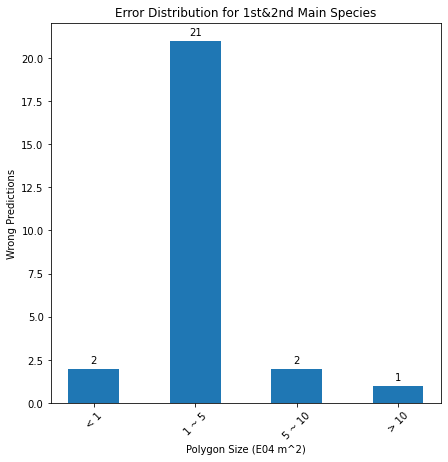

In [7]:
counts = [2, 21, 2, 1]
classes = ['< 1', '1 ~ 5', '5 ~ 10', '> 10']
title = 'Error Distribution for 1st&2nd Main Species'
fig, ax = plt.subplots(figsize=(7, 7))
bar_width = 0.5
bar_positions = [i for i in range(len(counts))]
bars = ax.bar(bar_positions, counts, width=bar_width)
# x,y label and title
ax.set_xticks(bar_positions)
ax.set_ylabel('Wrong Predictions')
ax.set_xlabel('Polygon Size (E04 m^2)')
ax.set_xticklabels(classes, rotation=45)
ax.set_title(title)
# show count value
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')
# save fig
plt.savefig('../outputs/pics/map/classification/'+ title +'.jpg')
# plt.show()

Top1 and Top2 Accuracy for AOI

In [34]:
top1_loc_acc = {'Hardtwald':{}, 'Schwarzwald':{}, 'schoenbuch':{}}
top2_loc_acc = {'Hardtwald':{}, 'Schwarzwald':{}, 'schoenbuch':{}}
for model in models:
    pred_path = os.path.join(PATH, f'{model}_{uid}_map.csv')
    pred = csv.load(pred_path, 'id')
    group = pred.groupby('Location')
    for key, df in group:
        loc = key.split('_')[0]
        total = df.shape[0]
        top1_loc_acc[loc][model] = sum(df['top_1']) / total
        top2_loc_acc[loc][model] = sum(df['top_2']) / total
print(top1_loc_acc)
print(top2_loc_acc)

{'Hardtwald': {'transformer': 0.8571428571428571, 'lstm': 0.7551020408163265, 'bi-lstm': 0.7551020408163265}, 'Schwarzwald': {'transformer': 0.48148148148148145, 'lstm': 0.5185185185185185, 'bi-lstm': 0.6296296296296297}, 'schoenbuch': {'transformer': 0.6923076923076923, 'lstm': 0.4945054945054945, 'bi-lstm': 0.5384615384615384}}
{'Hardtwald': {'transformer': 0.9591836734693877, 'lstm': 0.9183673469387755, 'bi-lstm': 0.9591836734693877}, 'Schwarzwald': {'transformer': 0.7037037037037037, 'lstm': 0.6481481481481481, 'bi-lstm': 0.7222222222222222}, 'schoenbuch': {'transformer': 0.9120879120879121, 'lstm': 0.7142857142857143, 'bi-lstm': 0.8241758241758241}}
